# Example for running three stage growth model

In [1]:
####### Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import yaml
import os, sys
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# MUST LOAD AFTER
import h5py
import warnings
warnings.filterwarnings("ignore")

sys.path.append('./util')
from util.IO import read_yaml_to_dict, get_parameter_output, run_model, h5_tree, read_h5, process_data
from util.plots import plot_results

ModuleNotFoundError: No module named 'seaborn'

### Execution of the model

In [8]:
template_path = '/Users/ryanschenck/Dropbox/Projects/FAP_Evo/cluster/util/conf.yaml'
output_path = '/Users/ryanschenck/Dropbox/Projects/FAP_Evo/cluster/outputs/'
julia = '/Applications/Julia-1.9.app/Contents/Resources/julia/bin/julia'
model = '/Users/ryanschenck/Dropbox/Projects/FAP_Evo/cluster/model/run_model.jl'

# Gets dictionary of parameters
template = read_yaml_to_dict(template_path)

# Update the template with additional parameters
# runID is the name of the output directory withint the output path!
# You can pass any value to this to update it!!!!! Even add NOTES you want saved in the yaml (category="neutral only")
updated_params = get_parameter_output(template_path,
                                      outpath=output_path,
                                      runID='test',
                                      verbose = 0,
                                      adv_mut_rate_polyp=0.0,
                                      s_coef_polyp=0.0) # Can change params here

# To run the model
run_model(updated_params, julia=julia, model=model)

### Loading Outputs

In [9]:
# updated_params is the dictionary of parameters that you can use to store info to load model results
# To load the model results
outdir = updated_params['outfile']
h5 = outdir + '/out.hdf5'
muts = outdir + '/muts.tsv'

out = read_h5(h5)
print(h5_tree(out))
muts = pd.read_csv(muts, sep='\t')

# Process data
# Label "Germline" and "Somatic"
# Convert time for inutero to months
# Convert VAF to ppVAF
popdf, muts = process_data(out, muts, outdir, min_vaf=0.0)

├── driver_muts
│   ├── fission (0)
│   ├── inutero (0)
│   └── polypfission (0)
├── mutId_delineator
│   └── delineator_muts (2)
├── params
│   ├── param_names (21)
│   └── values (21)
├── pops
│   ├── fission (21)
│   ├── inutero (10)
│   └── polypfission (21)
└── seed_genomes
    └── seed_genome_1 (411)
None


### Plot results

Two files that we are interested in were processed after model results.

First one is population information. It contains the population of each stage at each time step. The other is the mutation file with the post processing steps.

`population: post_pops.tsv`

`mutations: post_muts.tsv`

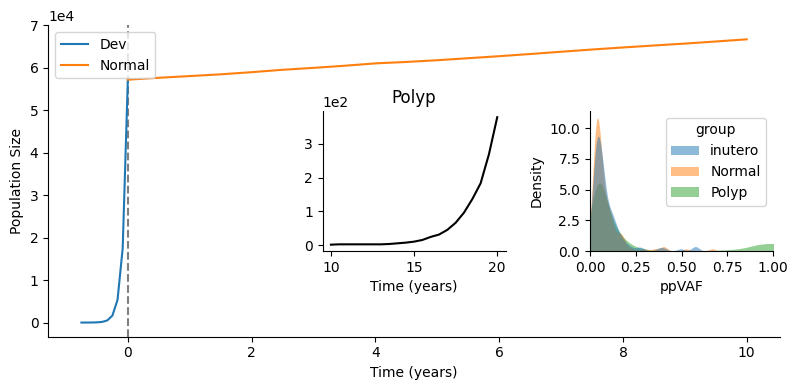

In [10]:
plot_results(popdf, muts, outpath=outdir)

In [4]:
f = read_h5('/N/users/rschenck/FAP/cluster/data/summary_stats/wes/A001C004.hdf5')
print(h5_tree(f))

└── A001C004
    ├── ccfs (62)
    ├── colectomy_age (1)
    ├── density (50)
    ├── num_clonal_subclonal_total (3)
    ├── probs (21)
    ├── stage (scalar)
    └── vafs (62)
None
